In [8]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

### 1. Ising model and denoising

In [9]:
with open("data4.txt", "r") as f:
    noise_image = [line.strip().split(" ") for line in f.readlines()]
    noise_image = np.array(noise_image, dtype=float).T

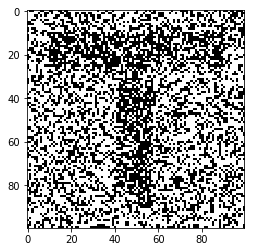

In [10]:
plt.imshow(noise_image, "gray")
plt.show()

In [12]:
class IsingGrid:
    def __init__(self, height, width, extfield, invtemp):
        self.width, self.height, self.extfield, self.invtemp = height, width, extfield, invtemp
        self.grid = np.zeros([self.width, self.height], dtype=np.int8) + 1
        
    def plot(self):
        plt.imshow(self.grid, cmap="gray", aspect="equal", interpolation="none", vmin=-1, vmax=1)
    
    def make_random(self):
        self.grid = (np.random.randint(0, 2, size = self.width * self.height).reshape(self.width, self.height) * 2) - 1
    
    def neighbours(self, x, y):
        n = []
        if x == 0:
            n.append( (self.width-1, y) )
        else:
            n.append( (x-1, y) )
        if x == self.width-1:
            n.append( (0, y) )
        else:
            n.append( (x+1, y) )
        if y == 0:
            n.append( (x, self.height-1) )
        else:
            n.append( (x, y-1) )
        if y == self.height-1:
            n.append( (x, 0) )
        else:
            n.append( (x, y+1) )
        return n
    
    def local_energy(self, x, y):
        return self.extfield + sum( self.grid[xx,yy] for (xx, yy) in self.neighbours(x, y) )
    
    def total_energy(self):
        # Could maybe do some numpy games here, but periodic boundary conditions make this tricky.
        # This function is only ever useful for very small grids anyway.
        energy = - self.extfield * np.sum(self.grid)
        energy += - sum( self.grid[x, y] * sum( self.grid[xx, yy] for (xx, yy) in self.neighbours(x, y) )
                        for x in range(self.width) for y in range(self.height) ) / 2
        return energy
    
    def probability(self):
        return np.exp( - self.invtemp * self.total_energy() )
    
    def gibbs_move(self):
        n = np.random.randint(0, self.width * self.height)
        y = n // self.width
        x = n % self.width
        p = 1 / (1 + np.exp(-2 * self.invtemp * self.local_energy(x,y)))
        if np.random.random() <= p:
            self.grid[x,y] = 1
        else:
            self.grid[x,y] = -1
            
    def from_number(self, n):
        """Convert an integer 0 <= n < 2**(width*height) into a grid."""
        binstring = bin(n)[2:]
        binstring = "0" * (N - len(binstring)) + binstring
        self.grid = np.array([int(x)*2-1 for x in binstring], dtype=np.int8).reshape(self.width, self.height)
    
    def to_number(self):
        """Convert grid into an integer."""
        flat = [self.grid[x, y] for x in range(self.width) for y in range(self.height)]
        return sum(2**n * (int(x)+1)//2 for n, x in enumerate(reversed(flat)))

class IsingGridVaryingField(IsingGrid):
    def __init__(self, height, width, extfield, invtemp):
        super().__init__(height, width, 0, invtemp)
        self.vextfield = extfield
        
    def local_energy(self, x, y):
        return self.vextfield[x,y] + sum( self.grid[xx,yy] for (xx, yy) in self.neighbours(x, y) )
    
def IsingDeNoise(noisy, q, burnin = 50000, loops = 500000, temp=0.5):
    inv_temp = 1/temp
    h = 0.5 * np.log(q / (1-q))
    gg = IsingGridVaryingField(noisy.shape[0], noisy.shape[1], h*noisy, inv_temp)
    gg.grid = np.array(noisy)
    
    # Burn-in
    for _ in range(burnin):
        gg.gibbs_move()
    
    # Sample
    avg = np.zeros_like(noisy).astype(np.float64)
    for _ in range(loops):
        gg.gibbs_move()
        avg += gg.grid
    return avg / loops


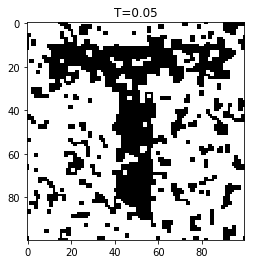

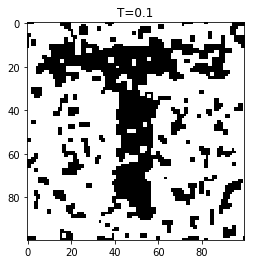

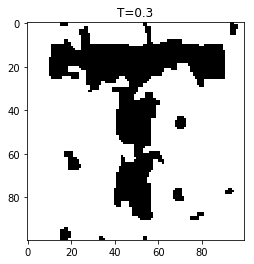

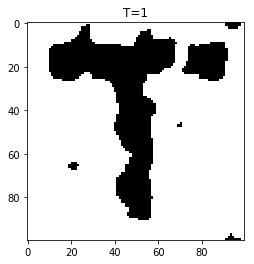

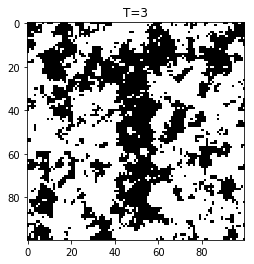

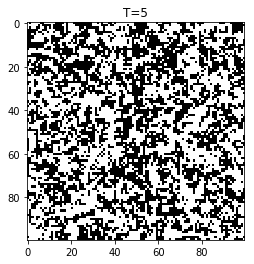

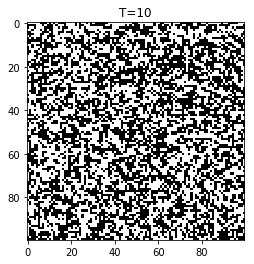

In [14]:
for t in [0.05,0.1,0.3,1,3,5,10]:
    avg = IsingDeNoise(noise_image, 0.625, temp=t)
    avg[avg >= 0] = 1
    avg[avg < 0] = -1
    avg = avg.astype(np.int)
    plt.title("T="+str(t))
    plt.imshow(avg, cmap="gray")
    plt.show()

ref: http://nbviewer.jupyter.org/github/MatthewDaws/Python_bits/blob/master/monte_carlo/Ising%20Model.ipynb

### 2. Decryption

In [15]:
# -*- coding: utf-8 -*-
import math
import random

alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ "

# 根据传入的密钥，生成字母替换规则字典
# 例如传入"DGHJKL..."，生成字典{D:A, G:B, H:C...}
def create_cipher_dict(cipher):
    cipher_dict = {}
    alphabet_list = list(alphabet)
    for i in range(len(cipher)):
        cipher_dict[alphabet_list[i]] = cipher[i]
    return cipher_dict

# 使用密钥对文本进行替换(加密/解密)
def apply_cipher_on_text(text,cipher):
    cipher_dict = create_cipher_dict(cipher) 
    text = list(text)
    newtext = ""
    for elem in text:
        if elem.upper() in cipher_dict:
            newtext+=cipher_dict[elem.upper()]
        else:
            newtext+=" "
    return newtext

# 统计参考语料的bigram
# 例如 {'AB':234,'TH':2343,'CD':23 ..}
def create_scoring_params_dict(longtext_path):
    scoring_params = {}
    alphabet_list = list(alphabet)
    with open(longtext_path) as fp:
        for line in fp:
            data = list(line.strip())
            for i in range(len(data)-1):
                alpha_i = data[i].upper()
                alpha_j = data[i+1].upper()
                if alpha_i not in alphabet_list and alpha_i != " ":
                    alpha_i = " "
                if alpha_j not in alphabet_list and alpha_j != " ":
                    alpha_j = " "
                key = alpha_i+alpha_j
                if key in scoring_params:
                    scoring_params[key]+=1
                else:
                    scoring_params[key]=1
    return scoring_params

# 统计解密文本的bigram
# 例如 {'AB':234,'TH':2343,'CD':23 ..}
def score_params_on_cipher(text):
    scoring_params = {}
    alphabet_list = list(alphabet)
    data = list(text.strip())
    for i in range(len(data)-1):
        alpha_i =data[i].upper()
        alpha_j = data[i+1].upper()
        if alpha_i not in alphabet_list and alpha_i != " ":
            alpha_i = " "
        if alpha_j not in alphabet_list and alpha_j != " ":
            alpha_j = " "
        key = alpha_i+alpha_j
        if key in scoring_params:
            scoring_params[key]+=1
        else:
            scoring_params[key]=1
    return scoring_params

# 根据公式计算密钥的评分
def get_cipher_score(text,cipher,scoring_params):
    decrypted_text = apply_cipher_on_text(text,cipher)
    scored_f = score_params_on_cipher(decrypted_text)
    cipher_score = 0
    for k,v in scored_f.items():
        if k in scoring_params:
            cipher_score += v*math.log(scoring_params[k])
    return cipher_score

# 通过随机交换两个字母的顺序 生成一个新的密钥
def generate_cipher(cipher):
    pos1 = random.randint(0, len(list(cipher))-1)
    pos2 = random.randint(0, len(list(cipher))-1)
    if pos1 == pos2:
        return generate_cipher(cipher)
    else:
        cipher = list(cipher)
        pos1_alpha = cipher[pos1]
        pos2_alpha = cipher[pos2]
        cipher[pos1] = pos2_alpha
        cipher[pos2] = pos1_alpha
        return "".join(cipher)

# 抛一枚出现正面概率为p的硬币，出现正面返回True，出现反面返回False
def random_coin(p):
    unif = random.uniform(0,1)
    if unif>=p:
        return False
    else:
        return True
    
# MCMC方法解密 运行n_iter轮
def MCMC_decrypt(n_iter,cipher_text,scoring_params):
    current_cipher = alphabet # 以随机密钥开始
    state_keeper = set()
    best_state = ''
    score = 0
    for i in range(n_iter):
        state_keeper.add(current_cipher)
        proposed_cipher = generate_cipher(current_cipher)
        score_current_cipher = get_cipher_score(cipher_text,current_cipher,scoring_params)
        score_proposed_cipher = get_cipher_score(cipher_text,proposed_cipher,scoring_params)
        
        acceptance_probability = min(1,math.exp(score_proposed_cipher-score_current_cipher))

#         if score_current_cipher>score:
#             best_state = current_cipher
        if (score_proposed_cipher>score_current_cipher):
            current_cipher = proposed_cipher
        elif random_coin(acceptance_probability):
            current_cipher = proposed_cipher
        if i%10000==0:
            print ("iter",i,":",apply_cipher_on_text(cipher_text,current_cipher)[0:99])
            print(score_current_cipher)
            print(score_proposed_cipher)
            
        best_state = current_cipher
    return state_keeper,best_state



# reference corpus
scoring_params = create_scoring_params_dict('war_and_peace.txt')

# 测试文本
with open("decode.txt", "r") as f:
    cipher_text = f.read()
    
print("Text To Decode:", cipher_text)
print()
states,best_state = MCMC_decrypt(100000,cipher_text,scoring_params)
print("\n")
print("Decoded Text:",apply_cipher_on_text(cipher_text,best_state))
print() 
print("MCMC KEY FOUND:",best_state)


Text To Decode: o rmaeqwzeqd rui wugelfuc zlfjuqgdcuna bzfyucg huqgfcfuh ajcuq uyfuhdqgui wauy rqfuoeaz uo jfcudpui wueafuqgfupdacqu rfudruqgfuozeccui waumaejfuhdzzubfueunzwcup auqgfucqeqdcqdoezuo ynwqdrmuneaqur uyeqqfaug hubejziui wuj udruqgfupdrezufsey

iter 0 : O RMAEQWZEQD RUI WUGEJFUC ZJFLUQGDCUNA BZFYUCG HUQGFCFUH ALCUQ UYFUHDQGUI WAUY RQFUOEAZ UO LFCUDPUI
1345.1926666259494
1384.4105609393205
iter 10000 : CONGRATULATION YOU HAVE SOLVED THIS PROBLEM SHOW THESE WORDS TO ME WITH YOUR MONTE CARLO CODES IF Y
2303.4626148011907
2298.4196622846785
iter 20000 : CONGRATULATION YOU HAKE SOLKED THIS BROPLEM SHOW THESE WORDS TO ME WITH YOUR MONTE CARLO CODES IF Y
2302.144483992723
2201.1295201580197
iter 30000 : CONGRATULATION YOU HAVE SOLVED THIS BROPLEM SHOW THESE WORDS TO ME WITH YOUR MONTE CARLO CODES IF Y
2303.699461806863
2128.6980243187363
iter 40000 : CONGRATULATION YOU HAKE SOLKED THIS BROPLEM SHOW THESE WORDS TO ME WITH YOUR MONTE CARLO CODES IF Y
2304.4046902414793
2278.066178290

ref: https://bindog.github.io/blog/2015/10/15/revisit-mcmc-method/